# Covariance Matrix methods
To find symplectic eigenvalues of the covariance matrix gives simple means to compute quantities such as Entropy or Purity.

**Problems**:
1. Quadrature-operators covariance matrix does not give correct mean photon number n1 and n2
2. Covariance matrix does not evolve correctly

In [1]:
%matplotlib inline
import copy
import qutip
from qutip import Qobj
import numpy as np
import math, cmath
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from stateobj import Physics
import utilities as use
import circuits as qc

import os

from IPython.display import Markdown, display

In [24]:
TIMESTEPS = 3000
TIMEDELTA = 1e-01
OMEGA = 0.5  # Strength of Interaction

D = 30

p = Physics(dimension=D, interaction_strength=OMEGA, interaction_time=TIMEDELTA)

th = OMEGA * TIMEDELTA
alpha = complex(1/math.sqrt(2), 0)
beta = cmath.sqrt(1 - alpha**2)
phi = np.pi/2

In [25]:
eta = use.create_ancilla_qobj(alpha, beta, phi)
n1 = 2
n2 = 1
rho1 = use.create_system_qobj('thermal',n=n1, n_dims=D)
rho2 = use.create_system_qobj('thermal', n=n2, n_dims=D)
rho = qutip.tensor(rho1, rho2)
# qutip.plot_wigner(rho)

def cov_matrix_element(op1, op2):
    comm = qutip.commutator(op1, op2, kind='anti')
    return 0.5*qutip.expect(comm, rho) - qutip.expect(op1, rho)*qutip.expect(op2, rho)

def create_covariance(operators):
    cov = [[cov_matrix_element(operators[k], operators[l]) for k in range(2*n)] for l in range(2*n)]
    return Qobj(cov, dims=[[n, n], [n, n]])

In [26]:
def dissipator(X: Qobj, system: Qobj, kind='standard'):
        if kind == 'inverse':
            sandwich = X.dag() * system * X
        else:
            sandwich = X * system * X.dag()
        comm = qutip.commutator(X.dag()*X, system, kind='anti')
        return sandwich - 1/2 * comm

def evolve(operator, dissipator_kind='standard'):
        ga = 2*alpha**2
        gb = beta**2*(1-np.cos(phi))
        # Bosonic Operators
        C = p.C
        Cp = p.Cp
        S = p.S
        Sd = p.S.dag()
        first_line = 0.5*dissipator(qutip.tensor(C, C) - 2*qutip.tensor(S, Sd), operator, dissipator_kind)
        first_line += dissipator(qutip.tensor(C, S) + qutip.tensor(S, Cp), operator, dissipator_kind)
        second_line = 0.5*dissipator(qutip.tensor(Cp, Cp) - 2*qutip.tensor(Sd, S), operator, dissipator_kind)
        second_line += dissipator(qutip.tensor(Cp, Sd) + qutip.tensor(Sd, C), operator, dissipator_kind)
        return operator + ga * first_line + gb * second_line

## Covariance Matrix

In [27]:
n = 2  # Number of systems
# Bosonic Operators Vector
a = [p.a1, p.ad1, p.a2, p.ad2]
# Quadrature Operators Vector
q = [p.q1, p.p1, p.q2, p.p2]
cov = create_covariance(q)
cov

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2.49980443 0.         0.         0.        ]
 [0.         2.49980443 0.         0.        ]
 [0.         0.         1.49999996 0.        ]
 [0.         0.         0.         1.49999996]]

## Symplectic Eigenvalues

In [36]:
def find_symplectic_eigenvalues(cov):
    omega1 = Qobj([[0, 1], [-1, 0]])
    omega = qutip.tensor(qutip.qeye(2), omega1)
    matrix = 1j*omega*cov
    symplectic = np.linalg.eigvals(matrix.full())
    # Returns only unique values rounded and sorted
    return np.sort(np.unique(np.abs(symplectic).round(decimals=3)))
nus = find_symplectic_eigenvalues(cov)
np.sort(nus)

array([1.5, 2.5])

### Entropy

In [37]:
def minientropy(x):
    x1 = 0.5 * (x+1)
    x2 = 0.5 * (x-1)
    return x1*np.log2(x1) - x2*np.log2(x2)

def entropy(nus):
    return sum([minientropy(nu) for nu in nus])

In [38]:
def purity(nus):
    return np.prod([1/nu for nu in nus])


## Evolution

In [57]:
evolved_operators = q
nus_evolution = np.array([nus])
for t in trange(250):
    evolved_operators = [evolve(op) for op in evolved_operators]
    cov = create_covariance(evolved_operators)
    new_nus = find_symplectic_eigenvalues(cov)
    nus_evolution = np.append(nus_evolution, [new_nus], axis=0)

100%|██████████| 250/250 [02:04<00:00,  2.01it/s]


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.54270633+0.00000000e+00j  0.        +0.00000000e+00j
  -0.16548968+0.00000000e+00j  0.        +3.04389169e-18j]
 [ 0.        +0.00000000e+00j  0.54270633+0.00000000e+00j
   0.        -3.04389169e-18j -0.16548968+0.00000000e+00j]
 [-0.16548968+0.00000000e+00j  0.        -3.04389169e-18j
   0.37458733+0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +3.04389169e-18j -0.16548968+0.00000000e+00j
   0.        +0.00000000e+00j  0.37458733+0.00000000e+00j]]

C:\Users\fedes\AppData\Local\Temp\ipykernel_6012\1622176515.py:4: RuntimeWarning: invalid value encountered in log2
  return x1*np.log2(x1) - x2*np.log2(x2)
C:\Users\fedes\AppData\Local\Temp\ipykernel_6012\1622176515.py:4: RuntimeWarning: divide by zero encountered in log2
  return x1*np.log2(x1) - x2*np.log2(x2)
C:\Users\fedes\AppData\Local\Temp\ipykernel_6012\1622176515.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return x1*np.log2(x1) - x2*np.log2(x2)


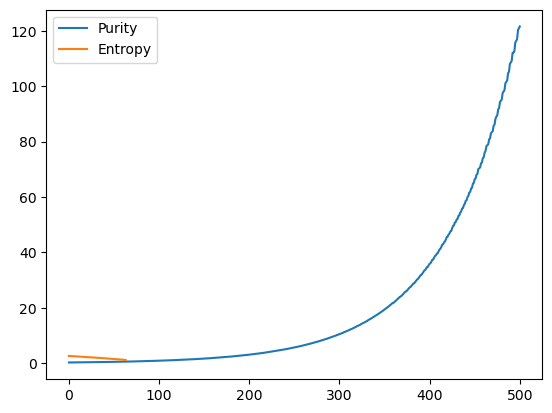

In [54]:
plt.plot([purity(nus) for nus in nus_evolution], label='Purity')
plt.plot([entropy(nus) for nus in nus_evolution], label='Entropy')
plt.legend()
plt.show()

In [12]:
nus_evolution

[array([1.5       , 1.5       , 1.93649163, 1.93649163]),
 array([1.4908518 , 1.4908518 , 1.92470259, 1.92470259]),
 array([1.48176658, 1.48176658, 1.91298983, 1.91298983]),
 array([1.47274387, 1.90135284, 1.90135284]),
 array([1.46378321, 1.8897911 ]),
 array([1.45488412, 1.45488412, 1.8783041 ]),
 array([1.44604616, 1.86689134, 1.86689134]),
 array([1.43726887, 1.8555523 , 1.8555523 ]),
 array([1.42855178, 1.42855178, 1.84428649, 1.84428649]),
 array([1.41989446, 1.83309342]),
 array([1.41129646, 1.41129646, 1.82197258, 1.82197258]),
 array([1.40275733, 1.40275733, 1.81092348, 1.81092348]),
 array([1.39427664, 1.79994565, 1.79994565]),
 array([1.38585394, 1.38585394, 1.78903859, 1.78903859]),
 array([1.37748882, 1.37748882, 1.77820183, 1.77820183]),
 array([1.36918084, 1.76743488, 1.76743488]),
 array([1.36092957, 1.75673729, 1.75673729]),
 array([1.35273459, 1.74610856]),
 array([1.34459548, 1.34459548, 1.73554825, 1.73554825]),
 array([1.33651184, 1.33651184, 1.72505588]),
 array([